# Chapter 3

## Working with different source formats and analytic techniques based on queries

This chapter illustrates working with metadata from multiple types of source files.  Data is incorporated into the DataJoint and NWB framework established in Chapter 1. We demonstrate a DataJoint bulk update, which populates the first node in the pipeline with information about the experimental subjects. Next, we iteratively read the remaining data from a standard file structure. This populates the DataJoint pipeline with the experimental data, which is used to demonstrate the analytical principles of querying techniques.  To illustrate a use case for data sharing, NWB files containing the desired subset of data are written to a shared directory.

## Part 1: Setup - Import libraries and DataJoint tables

In [1]:
#Libraries
import numpy as np
import os
import pynwb #NWB API
import pandas as pd
import h5py #Provides methods to supplement NWB
import datajoint as dj #
import csv 
#We use the Scipy library to read a Matlab file
import scipy.io
from datetime import datetime
from dateutil import tz
from pynwb import NWBHDF5IO
from matplotlib import pylab as plt

#We import our table definitions and DataJoint credentials
from ImportsAndTableDefinitions import *

Connecting marikelreimer@tutorial-db.datajoint.io:3306


We begin by importing the library and instantiating the tables.

In [2]:
#Before we can use them, the tables from chapter 1 must be instantiated:
mouse = Mouse()
session = Session()
position = Position()
positionStatistics = PositionStatistics()

Because we built logic into the position table, we can specify our source data:

In [3]:
file_type = 'NoseLocationLog.csv'

In [4]:
#Make sure we are working in the correct directory
experiment_path = 'C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1' #Your path here
os.chdir(experiment_path)

The image below is a representation of the directory structure that we will work with.  The root directory contains folders for each subject and they contain a folder for each session.  Each mouse has a one to many relationship with its experimental sessions. It is important to use the subject_id and the session_id in the folder naming convention as we use them to generate some metadata. Within each session folder, there are two csv files, one containing coordinates for position, the other containing metadata for each session.

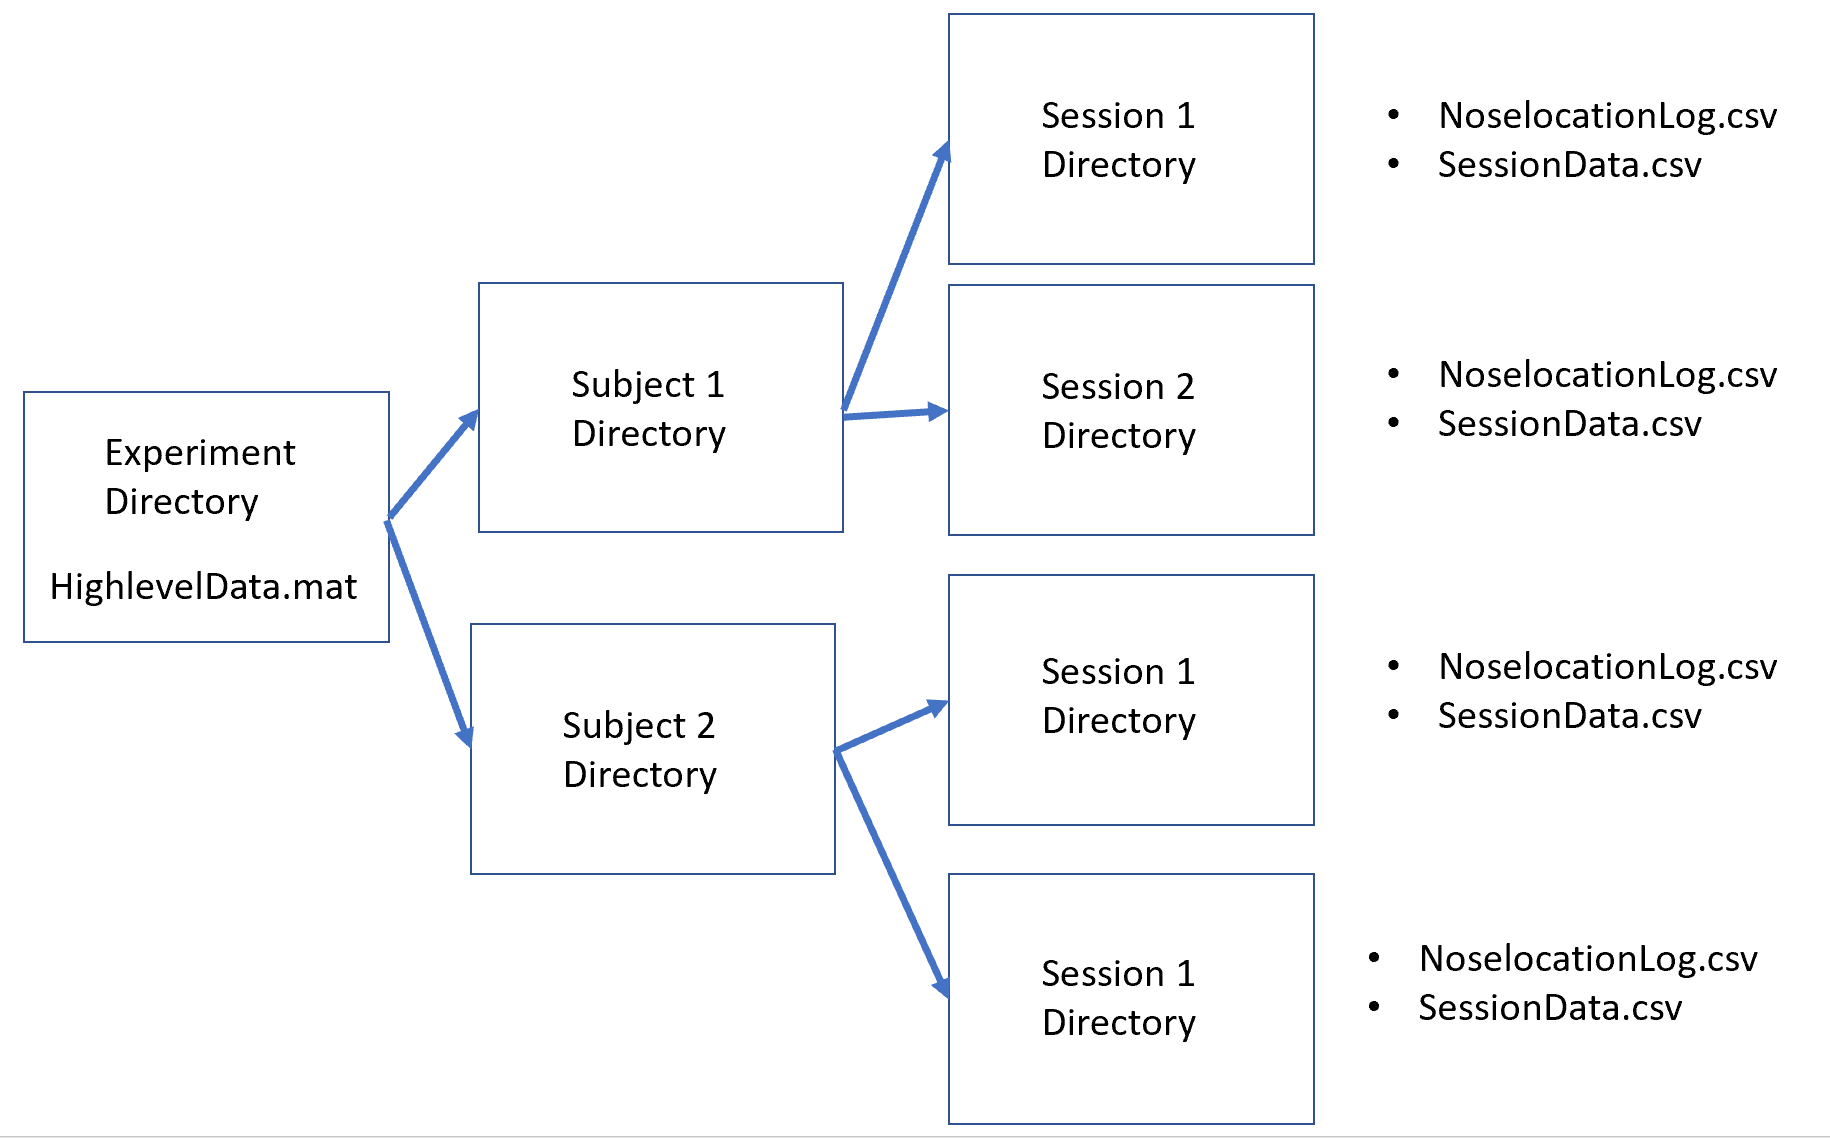

## Part 2: Bulk imports 

In [5]:
#We use DataJoint's bulk import function to load mouse meta data:

data = [
    {'subject_id': 'Mouse_5025', 'date_of_birth': datetime(2017, 4, 3, 11, tzinfo=tz.tzlocal()), 'genotype': 'B6', 'sex': 'F', 'species':'Mus musculus', 'subject_description': 'fuzzy', 'weight':'25g'},
    {'subject_id': 'Mouse_5026', 'date_of_birth': datetime(2017, 4, 3, 11, tzinfo=tz.tzlocal()), 'genotype': 'B6', 'sex': 'M',  'species':'Mus musculus', 'subject_description': 'fluffy','weight':'27g'},
    {'subject_id': 'Mouse_5027', 'date_of_birth': datetime(2017, 8, 10, 10, tzinfo=tz.tzlocal()), 'genotype': 'B6', 'sex': 'F', 'species':'Mus musculus', 'subject_description': 'silky', 'weight':'25g'}
]
mouse.insert(data)

#Alternatively, we could use a csv in each mouse's directory to store and access this data.

## Part 3: Traverse directories and ingest data 

In Chapter 1, we retrieved data from CSVs and the Jupyter notebook.  Next we extract data from a Matlab file to underscore how data standards promote interoperability between diverse file types.

In [6]:
#Read the Matlab file
high_level_data = scipy.io.loadmat('HighLevelData.mat')

#Extract the Matlab struct named high level data
high_level_data = high_level_data['high_level_data']

#Extract values stored in structs and convert them to the correct data type, e.g strings for these examples.
institution = str(high_level_data ['institution'][0,0][0])
lab = str(high_level_data ['lab'][0,0][0])
experiment_description = str(high_level_data ['experiment_description'][0,0][0])

We use the mouse and session folder names to create metadata about the subject and sessions.  Then we iterate through each session folder, extracting data from csv source files. When writing large block of code, it is advisable to write psuedocode, an english description of what the code does.

1) Create a list for all the subject folders in the root directory:
    For each mouse folder:
        2) Create a list of all sessions:
            For each session:              
                3) Create metadata based on folder names
                4) Create a link to the session folder
                5) Navigate to the session folder
                6) Create a dictionary with keys and values from CSV session data files
                7) Insert session data into DataJoint
                Populate the Position table      

For item 1, we create a list for all of the subject folders in the root directory

In [7]:
#We list all items in the directory
directory_list = os.listdir()

#create an empty list for the mouse folders
mouse_folder_list = []

#Check to see if items in root are directories then add directories to the mouse_folder_list
for item in directory_list:
    if os.path.isdir(item):
        mouse_folder_list.append(item)

Now we iterate through our list

In [8]:
for mouse_folder in mouse_folder_list:
    #Use the values stored in the list to access each mouse folder
    os.chdir(experiment_path + '/' + mouse_folder + '/')
    # 2) create a list of all the session folders in the mouse folders
    session_directory_list = os.listdir()

    for session_folder in session_directory_list: 
        # 3) Create metadata based on folder names
        #Mouse folders are labeled with the subject_id and session folders with the session ID
        subject_id = mouse_folder  
        name = session_folder
        identifier = subject_id + "_" + name #This uniquely identifies a file/dataset
        nwbfile_name = identifier + '.nwb' #The file identifier references the subject and the session
        
        #4) Create a link to the session folder
        #The remaining metadata is obtained by reading SessionData.csv and storing values in a dictionary
        raw_data_link = str(experiment_path + '/' + mouse_folder + '/' + session_folder + '/')
        
        #5) Navigate to the session folder
        os.chdir(raw_data_link)
        os.listdir()

        # 6)Create a dictionary for keys/values from SessionData.csv
        session_data_dictionary = {}

        # Read csv
        with open('SessionData.csv',  mode = 'r', encoding='utf-8-sig') as csvfile:
            reader = csv.reader(csvfile, delimiter=",")

            for row in reader:
                key, value = row
                session_data_dictionary[key] = value
        
        session_description = session_data_dictionary['description']
        starting_time = session_data_dictionary['starting_time']
        session_start_time = session_data_dictionary['session_start_time']
        experimenter = session_data_dictionary['experimenter']
        rate = session_data_dictionary['rate']
        comments = session_data_dictionary['comments']
        description = session_data_dictionary['description']
        reference_frame = session_data_dictionary['reference_frame']

        # 7) Insert session data into DataJoint            
        Session.insert1((
            subject_id, #Primary key for mouse table
            name, #Primary key for session table
            comments, 
            description,
            experiment_description, #From high level data
            experimenter, 
            identifier,
            institution, #From high level data
            lab, #From high level data
            rate,
            raw_data_link,
            reference_frame,
            session_description,
            session_start_time,
            starting_time
            ))
        
        # 8) Populate data in the Position table
        #Reading position data is a method we defined for the Position table, so we can load it with .populate()
        position.populate()

        os.chdir(experiment_path + '/' + mouse_folder + '/' )
        

Populated a position for Mouse_5025
Populated a position for Mouse_5025
Populated a position for Mouse_5025
Populated a position for Mouse_5025
Populated a position for Mouse_5026
Populated a position for Mouse_5026
Populated a position for Mouse_5026
Populated a position for Mouse_5026
Populated a position for Mouse_5027
Populated a position for Mouse_5027


We can now perform our analysis on our data set with a call to populate:

In [9]:
positionStatistics.populate()

Populating for:  {'subject_id': 'Mouse_5025', 'name': 'Session_19'}
Populating for:  {'subject_id': 'Mouse_5025', 'name': 'Session_20'}
Populating for:  {'subject_id': 'Mouse_5025', 'name': 'Session_21'}
Populating for:  {'subject_id': 'Mouse_5025', 'name': 'Session_22'}
Populating for:  {'subject_id': 'Mouse_5026', 'name': 'Session_17'}
Populating for:  {'subject_id': 'Mouse_5026', 'name': 'Session_18'}
Populating for:  {'subject_id': 'Mouse_5026', 'name': 'Session_19'}
Populating for:  {'subject_id': 'Mouse_5026', 'name': 'Session_20'}
Populating for:  {'subject_id': 'Mouse_5027', 'name': 'Session_7'}
Populating for:  {'subject_id': 'Mouse_5027', 'name': 'Session_8'}


# Populated Data Pipeline

The data has been successfully loaded into the pipeline and our dataset is ready for analysis.  By using the * operator,  DataJoint's joins our tables together.

In [10]:
mouse * session * position * positionStatistics

subject_id Primary keys above the '---',name Primary key for the session table,date_of_birth,genotype,sex,species,subject_description,weight,comments,description Timeseries description,experiment_description,experimenter,identifier,institution,lab,rate,raw_data_link,reference_frame,session_description,session_start_time,starting_time,"coordinates X,Y coordinates of mouse",left_side coordinates in left half,right_side coordinates in the right half,preference_index left_side - right_side/ left_side + right_side
Mouse_5025,Session_19,2017-04-03 11:00:00,B6,F,Mus musculus,fuzzy,25g,Will need to correct camera jitter,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5025_Session_19,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5025/Session_19/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 11:05:18,0.0,=BLOB=,10255.0,7102.0,0.181656
Mouse_5025,Session_20,2017-04-03 11:00:00,B6,F,Mus musculus,fuzzy,25g,Mouse fell asleep,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5025_Session_20,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5025/Session_20/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 11:17:24,0.0,=BLOB=,11972.0,8366.0,0.177304
Mouse_5025,Session_21,2017-04-03 11:00:00,B6,F,Mus musculus,fuzzy,25g,Mouse fell asleep,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5025_Session_21,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5025/Session_21/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 11:29:13,0.0,=BLOB=,9571.0,11261.0,-0.0811252
Mouse_5025,Session_22,2017-04-03 11:00:00,B6,F,Mus musculus,fuzzy,25g,Mouse was jumpier than usual,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5025_Session_22,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5025/Session_22/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 15:15:14,0.0,=BLOB=,9856.0,7912.0,0.10941
Mouse_5026,Session_17,2017-04-03 11:00:00,B6,M,Mus musculus,fluffy,27g,Will need to fix camera glitch,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5026_Session_17,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5026/Session_17/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 11:47:23,0.0,=BLOB=,10406.0,9132.0,0.0652063
Mouse_5026,Session_18,2017-04-03 11:00:00,B6,M,Mus musculus,fluffy,27g,Will need to fix camera glitch,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5026_Session_18,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5026/Session_18/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 12:13:47,0.0,=BLOB=,7076.0,2537.0,

## Part 4: Querying data
Our first query simply looks for all female mice

In [11]:
mouse & 'sex = "F"'

subject_id Primary keys above the '---',date_of_birth,genotype,sex,species,subject_description,weight
Mouse_5025,2017-04-03 11:00:00,B6,F,Mus musculus,fuzzy,25g
Mouse_5027,2017-08-10 10:00:00,B6,F,Mus musculus,silky,25g


Date of birth can also be used to filter mice

In [12]:
mouse & 'date_of_birth < "2017-08-10"'

subject_id Primary keys above the '---',date_of_birth,genotype,sex,species,subject_description,weight
Mouse_5025,2017-04-03 11:00:00,B6,F,Mus musculus,fuzzy,25g
Mouse_5026,2017-04-03 11:00:00,B6,M,Mus musculus,fluffy,27g


We designed our position statistics table to look a ratio of time spent on each side of the arena.  What if we wanted to take a simple difference?  For this we would use the proj() function to compute a new value called 'difference'.  This function is extremely useful for data exploration because analyses can be performed without needing to define new tables.

In [13]:
data_exploration = mouse * session * positionStatistics
difference = ''
data_exploration.proj(difference = 'left_side - right_side')

subject_id Primary keys above the '---',name Primary key for the session table,difference calculated attribute
Mouse_5025,Session_19,3153.0
Mouse_5025,Session_20,3606.0
Mouse_5025,Session_21,-1690.0
Mouse_5025,Session_22,1944.0
Mouse_5026,Session_17,1274.0
Mouse_5026,Session_18,4539.0
Mouse_5026,Session_19,5094.0
Mouse_5026,Session_20,4853.0
Mouse_5027,Session_7,-8213.0
Mouse_5027,Session_8,-9926.0


Projections can also filter results:

In [14]:
data_exploration.proj(difference='left_side - right_side')  & 'difference < 0'

subject_id Primary keys above the '---',name Primary key for the session table,difference calculated attribute
Mouse_5025,Session_21,-1690.0
Mouse_5027,Session_7,-8213.0
Mouse_5027,Session_8,-9926.0


We want to share data for the mice which have a side bias. We can query the field for preference_index to find mice which have a bias for the right half of the arena. 

In [15]:
side_bias = mouse * session * position * positionStatistics & 'preference_index < "0"'
side_bias

subject_id Primary keys above the '---',name Primary key for the session table,date_of_birth,genotype,sex,species,subject_description,weight,comments,description Timeseries description,experiment_description,experimenter,identifier,institution,lab,rate,raw_data_link,reference_frame,session_description,session_start_time,starting_time,"coordinates X,Y coordinates of mouse",left_side coordinates in left half,right_side coordinates in the right half,preference_index left_side - right_side/ left_side + right_side
Mouse_5025,Session_21,2017-04-03 11:00:00,B6,F,Mus musculus,fuzzy,25g,Mouse fell asleep,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5025_Session_21,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5025/Session_21/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 11:29:13,0.0,=BLOB=,9571.0,11261.0,-0.0811252
Mouse_5027,Session_7,2017-08-10 10:00:00,B6,F,Mus musculus,silky,25g,Will need to fix camera glitch,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5027_Session_7,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5027/Session_7/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 14:21:59,0.0,=BLOB=,4443.0,12656.0,-0.48032
Mouse_5027,Session_8,2017-08-10 10:00:00,B6,F,Mus musculus,silky,25g,Will need to fix camera glitch,"The position of a mouse in an arena is transformed into X,Y coordinates",Demonstrate bulk data imports of mouse position data and metadata,Experimenter 1,Mouse_5027_Session_8,Yale University,Tan Lab,30.0,C:/Users/meowm/OneDrive/DataWarehouse/Experimenter1/Mouse_5027/Session_8/,"Zero refers to the bottom left corner of the rig, when viewed from above","The position of a mouse in an arena is transformed into X,Y coordinates",2019-08-02 14:21:22,0.0,=BLOB=,4731.0,14657.0,-0.511966


We use DataJoint's fetch function to return our data as a list of dictionaries

In [16]:
dictionary_list = side_bias.fetch(as_dict=True)

Change path to the ShareFiles folder

In [17]:
sharedFiles = 'C:/Users/meowm/OneDrive/DataWarehouse/SharedFiles'
os.chdir(sharedFiles)

For each dictionary that we fetched, we pass the data to an NWB file.  Although large code blocks can be daunting, this is a simple sequence of steps:

- 1) Retrieve Subject data from dictionary
- 2) Pass Subject data to NWB
- 3) Retrieve Session Data
- 4) Create high level NWB structure and pass in high level data
- 5) Retrieve Session timeseries data 
- 6) Create an NWB timeseries
- 7) Create a module called 'behavior'
- 8) Add the timeseries to the 'behavior' module
- 9) Write data to file
- 10) Retrieve preference index value from DataJoint
- 11) Append preference index to NWB file

In [18]:
for dictionary in dictionary_list:
    # 1) Retrieve Subject data from dictionary
    subject_id = dictionary.get('subject_id')

    date_of_birth = dictionary.get('date_of_birth')
    sex = dictionary.get('sex')
    subject_description = dictionary.get('subject_description')
    genotype = dictionary.get('genotype')
    species = dictionary.get('species')
    weight = dictionary.get('weight')

    #2) Pass Subject data to NWB
    subject = pynwb.file.Subject(
        description = subject_description, #whereever possible we adopted NWB naming conventions, but description is used in the timeseries
        genotype = genotype,
        sex = sex,
        species = species,
        subject_id = subject_id,
        weight = weight,
        date_of_birth = date_of_birth
        )
        
    # 3) Retrive Session Data    
    session_description = dictionary.get('session_description')
    identifier = dictionary.get('identifier')
    session_start_time = dictionary.get('session_start_time')
    experimenter = dictionary.get('experimenter')
    lab = dictionary.get('lab')
    institution = dictionary.get('institution')
    experiment_description = dictionary.get('experiment_description')

    # 4) Create high level NWB structure and pass in high level Session Data  
    nwbfile = pynwb.NWBFile(
        session_description,
        identifier, 
        session_start_time, 
        experimenter = experimenter,
        lab = lab,
        institution = institution,
        experiment_description = experiment_description,
        subject = subject
        )
        
    # 5) Retrieve Session timeseries data 
    name = dictionary.get('name')     
    data = dictionary.get('coordinates')
    reference_frame = dictionary.get('reference_frame')
    starting_time = dictionary.get('starting_time')
    rate = dictionary.get('rate')
    comments = dictionary.get('comments') 
    description = dictionary.get('description')
            
    # 6) Create an NWB timeseries
    my_timeseries = pynwb.behavior.SpatialSeries(
        name, 
        data, 
        reference_frame = reference_frame,
        starting_time = starting_time,
        rate = rate, #Unit is Hz
        comments = comments, 
        description = description
        )

    # 7) Create a module in the Processing group called 'behavior' 
    behavior_module = nwbfile.create_processing_module('behavior', 'Spatial series containing coordinates representating the location of a mouse')

    # 8) Add the timeseries to the behavior module
    nwbfile.processing['behavior'].add(my_timeseries)
    
    # 9) Write data to file
    #Create file identifier
    nwbfile_name = identifier + '.nwb'

    #Write NWB file
    with NWBHDF5IO(nwbfile_name, 'w') as io:
        io.write(nwbfile)
        
    # 10) Retrieve preference index value from DataJoint
    preference_index = dictionary.get('preference_index')

    # 11) Append preference index to NWB file
    with h5py.File(nwbfile_name, 'a') as f:
        d = f['analysis']
        d.create_dataset("preference_index", data = preference_index)


C:\Users\meowm\AppData\Local\Continuum\anaconda3\lib\site-packages\pynwb\file.py:749: UserWarning:

Date is missing timezone information. Updating to local timezone.



In [19]:
#There should now be  NWB files the shared directory, use this code to check

list = os.listdir(sharedFiles) # dir is your directory path
print(list)

['Mouse_5025_Session_21.nwb', 'Mouse_5027_Session_7.nwb', 'Mouse_5027_Session_8.nwb']


This concludes Chapter 3. As before, we clear the pipeline before the next chapter

In [20]:
mouse.drop()

`marikelreimer_tutorial`.`mouse` (3 tuples)
`marikelreimer_tutorial`.`session` (10 tuples)
`marikelreimer_tutorial`.`_position` (10 tuples)
`marikelreimer_tutorial`.`__position_statistics` (10 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.
